In [9]:
import pandas as pd             # to use Dataframes
import matplotlib.pyplot as plt # to plot results
import datetime                 # to work with dates
import numpy as np              # to perform mathematical operations
import plotly.express as px     # to make interactive plots

In [10]:
df_owid_orig = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')

In [11]:
# Work with a copy, not the original dataset
df_owid = df_owid_orig.copy()

# Store the location and date as indices for the dataframe
df_owid.sort_values(by=['location', 'date'])
df_owid.loc[:, 'datetime'] = pd.to_datetime(df_owid.loc[:, 'date'])
df_owid = df_owid.set_index(['location', 'datetime'], drop=False)
df_owid.rename_axis(['location_index', 'datetime_index'], axis='index', inplace=True)

# Count the number of days since beginning of recording - helps with regression model
df_owid['days_since'] = (df_owid['datetime'] - df_owid['datetime'].iloc[0]).dt.days

In [42]:
ListofStates = ['Alabama', 'Texas', 'New York State']
train_date_limit = datetime.datetime.strptime('2021-03-15', '%Y-%m-%d')

In [62]:
df_states = df_owid.loc[ListofStates]

In [44]:
df_states.columns

Index(['date', 'location', 'total_vaccinations', 'total_distributed',
       'people_vaccinated', 'people_fully_vaccinated_per_hundred',
       'total_vaccinations_per_hundred', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'distributed_per_hundred',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'share_doses_used', 'datetime',
       'days_since'],
      dtype='object')

In [246]:
# fig = plt.figure(num=None, figsize=(10, 8))
# ax = df_owid.loc[state]['share_doses_used'].plot()
# for state in ListofStates:
#     if state == ListofStates[0]:
#         pass
#     else:
#         df_owid.loc[state]['share_doses_used'].plot(ax=ax)

In [106]:
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# ListofStates = ['Alabama', 'Texas', 'New York State']
# ListofCols = ['share_doses_used', 'people_vaccinated_per_hundred']

# fig = make_subplots(rows=len(ListofCols)+1,cols=1,shared_xaxes=True)

# lines = []
# for state in ListofStates:
#     for col_idx, col in enumerate(ListofCols):
#         data = go.Scatter(x=df_owid.loc[state]['datetime'], y=df_owid.loc[state][col], name=state+' '+col)   
#         fig.add_trace(data, row=col_idx+1, col=1)

# fig.show()

In [245]:
# df_owid.loc[state][col]

In [70]:
# state_data1 = df_states.loc['Texas']
# axes = state_data1.plot('datetime', 'share_doses_used')
# state_data2 = df_states.loc['Alabama']
# state_data2.plot('datetime', 'share_doses_used')

In [244]:
# df_states

In [107]:
# for idx, state in enumerate(ListofStates):
#     state_data = df_states.loc[state]
#     if idx == 0:
#         axes = state_data.plot('datetime', 'share_doses_used')
#     else:
#         state_data.plot('datetime', 'share_doses_used')
#         df_states.plot(ax=axes)

In [108]:
# fig_efficiency = plt.plot(figsize=[13,13])

# for state in ListofStates:
#     state_data = df_states.loc['share_doses_used']
#     state_data.plot('datetime', 'share_doses_used')
#     plt.show()

In [164]:
# def getLr(X_trn, X_tst, y_trn, y_tst):
#     mdl = LinearRegression()
#     mdl.fit(X_trn, y_trn)
#     y_prd = mdl.predict(X_tst)
#     y_prd = pd.Series(y_prd, index=y_tst.index)
    
#     return y_prd, mdl

In [165]:
train_date_end = datetime.datetime.strptime('2021-03-15', '%Y-%m-%d')
train_date_start = train_date_limit - datetime.timedelta(5)

In [238]:
from sklearn.linear_model import LinearRegression

def getLinreg(X_trn, y_trn):
    mdl = LinearRegression()
    mdl.fit(X_trn, y_trn)
    
    return mdl

In [239]:
TrainData = df_owid.loc[state][train_date_start:train_date_end]
X_train = TrainData['days_since']
Y_train = TrainData[['share_doses_used', 'people_vaccinated_per_hundred']]

In [742]:
days_ahead = 100
forecast_dates = pd.date_range(train_date_end, train_date_end+datetime.timedelta(days_ahead))

Y_pred_state = []
indices = [[ state for day in range(days_ahead+1) ], forecast_dates]
for state in ListofStates:
    Y_pred_state.append( pd.DataFrame(columns=ListofCols, index=indices) )
Y_pred = pd.concat(Y_pred_state)

y_pred_list = []
y_p_state_list = []

for state in ListofStates:
    for idx, col in enumerate(Y_train.columns):
        slope = getLinreg(np.array(X_train).reshape(-1, 1), Y_train[col]).coef_[0]
        train_end_point = (Y_train.index[-1], Y_train[col][-1])
        y_linreg = [ train_end_point[1] + slope*day for day in range(days_ahead+1) ]
        y_forecast = pd.DataFrame(data=y_linreg, columns=[col], index=forecast_dates)
        y_pred_list.append(y_forecast)
    y_p_state_list.append(y_pred_list[-1].join(y_pred_list[-2]))

Y_pred = pd.concat(y_p_state_list, keys=ListofStates)

In [434]:
for idx, col in enumerate(Y_train.columns):
    print(col)

share_doses_used
people_vaccinated_per_hundred


In [312]:
# start = train_end_point[0]
# end = start + datetime.timedelta(100)
# forecast_time = np.linspace(start.value, end.value, 101)
# forecast_time = pd.to_datetime(forecast_time)

# forecast_days_since = (forecast_time - df_owid['datetime'].iloc[0]).astype(int)/10**9/60/60/24
# forecast_days_since

Float64Index([ 62.0,  63.0,  64.0,  65.0,  66.0,  67.0,  68.0,  69.0,  70.0,
               71.0,
              ...
              153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0,
              162.0],
             dtype='float64', length=101)

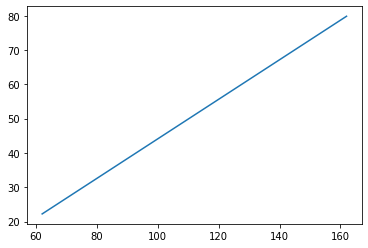

In [319]:
x_la = (forecast_days_since-forecast_days_since[0])
y_la = x_la * slope + train_end_point[1]
plt.plot(forecast_days_since, y_la)

In [203]:
np.linspace(0, 3, 10)

array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ])

In [ ]:
 = getLr(X_train, X_test, y_train, y_test)